In [1]:
import sys, os
import xsimlab as xs
import xarray as xa
import pandas as pd
import numpy as np
import sparse
import igraph as ig
import ipywidgets as widgets

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import carbon_unit

model = fruit_model.update_processes({ 'carbon_unit': carbon_unit.Identity })
#model = model.drop_processes(['carbon_unit', 'light', 'photo', 'carbon', 'fruit_quality', 'fruit_growth', 'pheno_flower', 'pheno_leaf', 'gu_growth'])
#model = model.drop_processes(['light', 'photo', 'pheno_leaf', 'gu_growth', 'fruit_quality', 'carbon', 'carbon_unit'])
model

<xsimlab.Model (15 processes, 11 inputs)>
params
    path                     [in]
    seed                     [in]
env
topo
    is_apical             [inout] ('GU',) 
    adjacency             [inout] ('GU', 'GU') 
    nb_leaves_gu          [inout] ('GU',) 
pheno_flower
    bloom_date            [inout] ('GU',) bloom date
pheno_gu
pheno_leaf
fruit_growth
    nb_fruits_ini         [inout] ('GU',) 
inflo_growth
gu_growth
gu_burst
    burst_t_apical           [in]
    burst_t_lateral          [in]
    gu_bursted            [inout] ('GU',) 
    gu_bursted_is_apical  [inout] ('GU',) 
carbon_unit
light
photo
carbon
fruit_quality

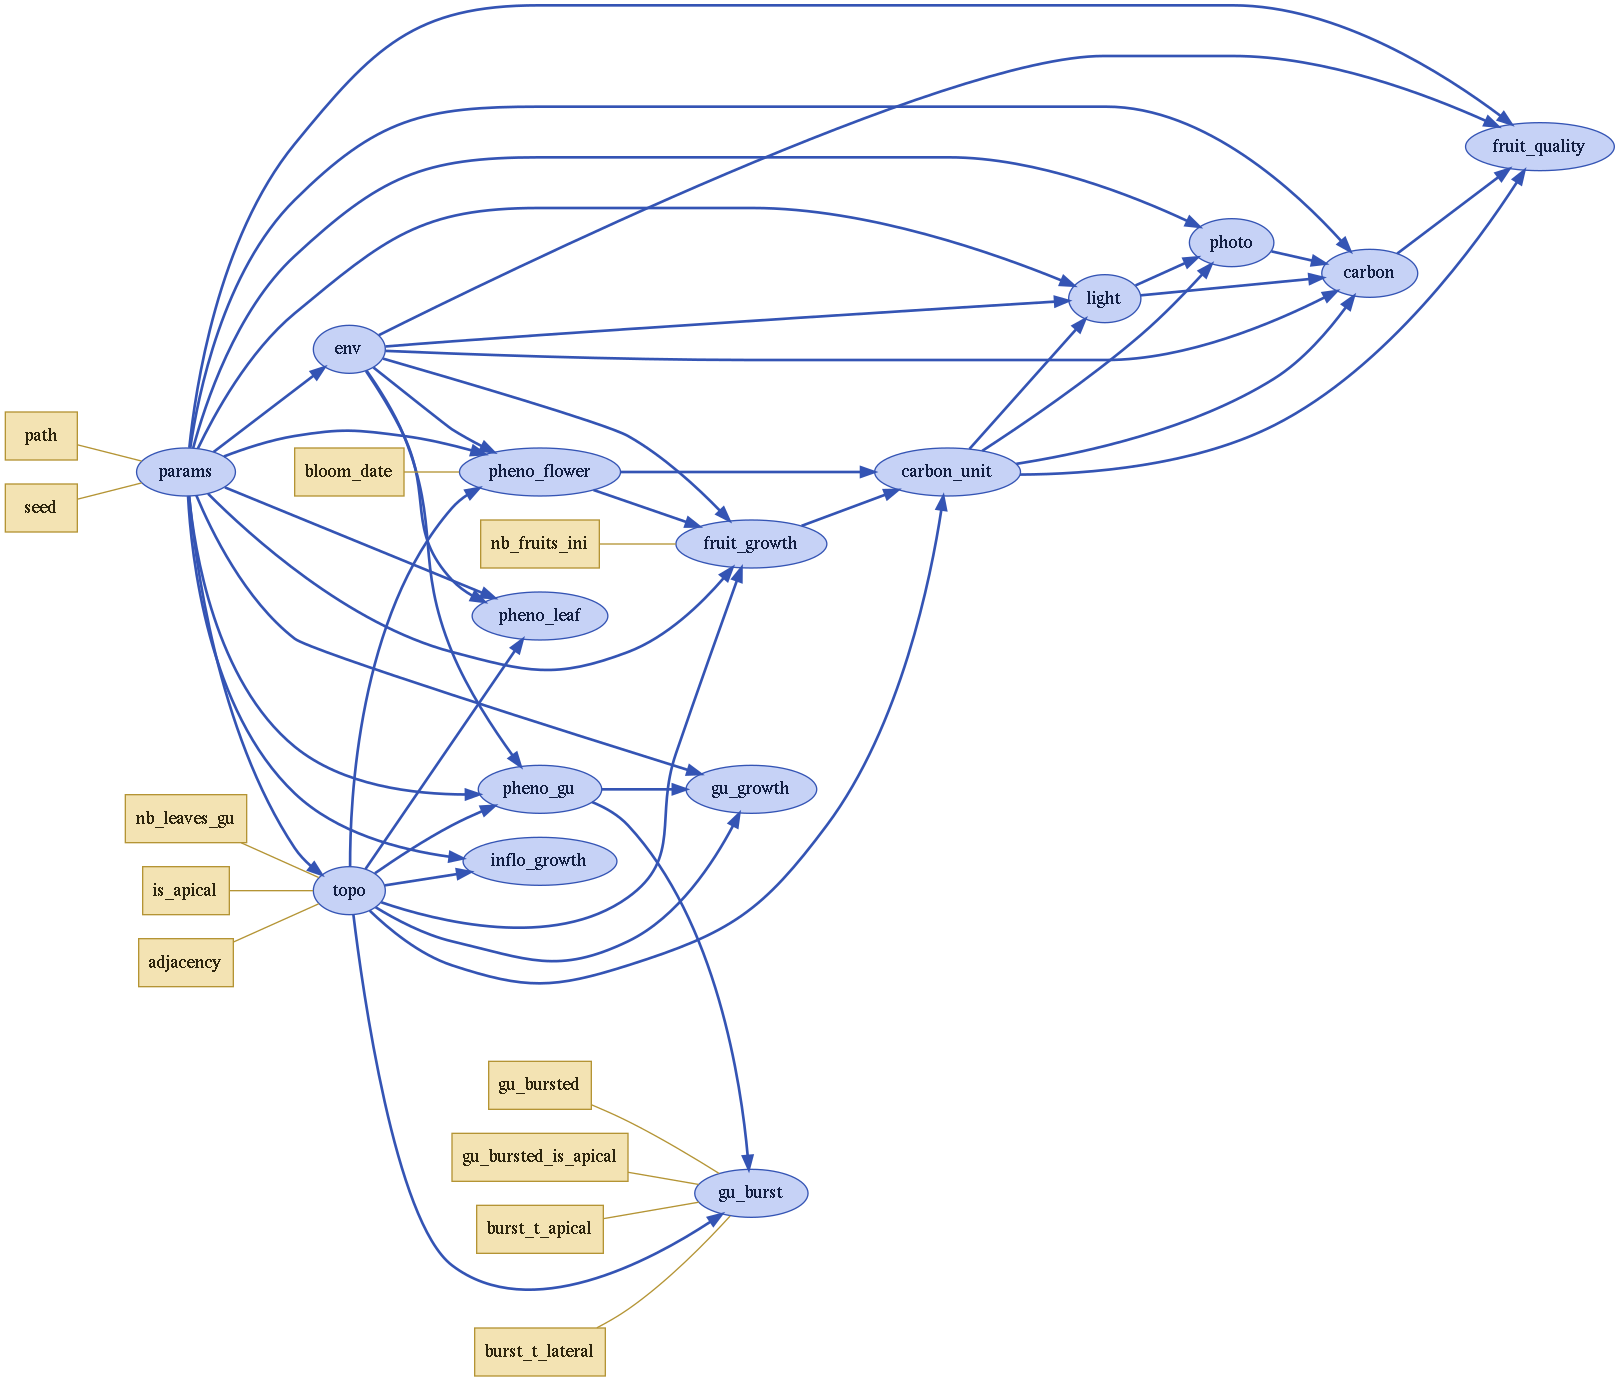

In [3]:
model.visualize(show_inputs=True, show_variables=False)

In [4]:
ds = vmlab.create_setup(
    model=model,
    clocks={
        'day': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1d"),
        'week': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1W")
    },
    master_clock='day',
    input_vars={
        'params': {
            'seed': 0,
            'path': '../share/setup/default.toml'
        },
        'gu_burst': {
            'burst_t_apical': 900, # remove facet plots if this number is low -> many GUs
            'burst_t_lateral': 1000, # remove facet plots if this number is low -> many GUs
            'gu_bursted': [False, False, False, False, False, False, False],
            'gu_bursted_is_apical': [False, False, False, False, False, False, False]
        },
        'topo': {
            'adjacency': sparse.COO(np.array([
                    [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]
                ]).transpose(), True, shape=(7, 7)),
            'is_apical': [False, False, False, True, False, False, False],
            'nb_leaves_gu': [0, 5, 10, 25, 50, 100, 150]
        },
        'fruit_growth': {
            'nb_fruits_ini': [1, 1, 1, 1, 1, 1, 1]
        },
        'pheno_flower': {
            'bloom_date': [
                '2001-11-01',
                '2002-11-01',
                '2002-11-01',
                '2002-11-01',
                '2002-11-01',
                '2002-11-01',
                '2002-11-01'
            ]
        }
    }
)

In [5]:
ds

Format,coo
Data Type,bool
Shape,"(7, 7)"
nnz,6
Density,0.12244897959183673
Read-only,True
Size,102
Storage ratio,2.1


In [6]:
out = widgets.Output(layout=widgets.Layout(width='100%', height='800px'))
stage_color = {'A':'grey', 'B':'green', 'C':'yellow', 'D':'orange'}
@xs.runtime_hook('run_step')
def runtime_hook(model, context, state):
    if context['step'] % 7 == 0 or context['step'] == context['nsteps'] - 1:
        GU = state[('topo', 'GU')]
        adjacency = state[('topo', 'adjacency')]
        is_apical = state[('topo', 'is_apical')]
        gu_growth_tts = state[('pheno_gu', 'gu_growth_tts')]
        gu_stage = state[('pheno_gu', 'gu_stage')]
        g = ig.Graph.Adjacency(list(np.ones(adjacency.shape) * adjacency))
        l = g.layout_reingold_tilford(root=0)
        l.rotate(-90)
        style = {
            'vertex_size': 7,
            'vertex_color': [stage_color[s] for s in gu_stage],
            'vertex_label_size': 15,
            #'vertex_label': [int(t) for s,t in zip(gu_stage, gu_growth_tts)],
            'edge_arrow_size': 0,
            'edge_arrow_width': 1
        }
        with out:
            out.clear_output()
            print(context['step'] + 1, '/' ,context['nsteps'], 'GU:', GU.shape[0])
            display(ig.plot(g, layout=l, bbox = (800, 500), margin=(20, 20, 20, 20), **style))
out

Output(layout=Layout(height='800px', width='100%'))

In [7]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[runtime_hook])

/home/jv/git/jvail/vmango-lab/notebooks/../vmlab/processes/carbon_unit.py:125: RuntimeWarning: Mean of empty slice
  self.DM_fruit_0 = np.nan_to_num(np.nanmean(DM_fruit_0, 1), copy=False)
/home/jv/git/jvail/vmango-lab/notebooks/../vmlab/processes/carbon_unit.py:129: RuntimeWarning: Mean of empty slice
  self.dd_delta = np.nan_to_num(np.nanmean(dd_delta, 1), copy=False)
/home/jv/git/jvail/vmango-lab/notebooks/../vmlab/processes/carbon_unit.py:133: RuntimeWarning: Mean of empty slice
  self.dd_cum = np.nan_to_num(np.nanmean(dd_cum, 1), copy=False)
/home/jv/git/jvail/vmango-lab/notebooks/../vmlab/processes/carbon_balance.py:362: UserWarning: Vegetative part of the system dies ...
  warnings.warn('Vegetative part of the system dies ...')


In [8]:
ds_out

<xarray.Dataset>
Dimensions:                                (CU: 22, GU: 22, day: 208, hour: 24, week: 29)
Coordinates:
  * CU                                     (CU) <U10 'CU0' 'CU1' ... 'CU21'
  * GU                                     (GU) <U10 'GU0' 'GU1' ... 'GU21'
  * day                                    (day) datetime64[ns] 2002-09-02 .....
  * hour                                   (hour) int8 0 1 2 3 4 ... 20 21 22 23
  * week                                   (week) datetime64[ns] 2002-09-08 ....
Data variables:
    carbon__DM_fruit                       (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__DM_fruit_delta                 (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__DM_structural_leaf             (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__DM_structural_stem             (day, CU) float64 53.66 ... 53.66
    carbon__D_fruit                        (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__MR_fruit                       (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__MR_leaf                        (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__MR_repro                       (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__MR_stem                        (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__MR_veget                       (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__assimilates                    (day, CU) float64 0.04289 ... 0.0
    carbon__remains_1                      (day, CU) float64 0.04289 ... 0.0
    carbon__remains_2                      (day, CU) float64 0.04289 ... 0.0
    carbon__remains_3                      (day, CU) float64 0.04289 ... 0.0
    carbon__required_DM_fruit              (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__reserve_leaf                   (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__reserve_leaf_max               (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__reserve_mob                    (day, CU) float64 0.04289 ... 0.0
    carbon__reserve_nmob_leaf              (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon__reserve_nmob_stem              (day, CU) float64 2.573 2.573 ... 0.0
    carbon__reserve_stem                   (day, CU) float64 2.616 2.616 ... 0.0
    carbon_unit__CUxGU                     (day, CU, GU) float64 1.0 0.0 ... 1.0
    carbon_unit__DM_fruit_0                (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon_unit__DM_fruit_max              (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon_unit__dd_cum                    (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon_unit__dd_delta                  (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon_unit__nb_fruits                 (day, CU) float64 0.0 0.0 ... 0.0 0.0
    carbon_unit__nb_leaves                 (day, CU) float64 0.0 5.0 ... 0.0 0.0
    env__GR                                (day, hour) float64 0.0 0.0 ... 0.0
    env__RH                                (day, hour) float64 76.0 ... 78.0
    env__TM                                (day) float64 21.6 20.9 ... 24.85
    env__TM_air                            (day, hour) float64 20.7 ... 24.85
    env__T_air                             (day, hour) float64 17.1 ... 21.3
    env__T_fruit                           (day, hour) float64 17.1 ... 21.3
    fruit_growth__DM_fruit_0_gu            (day, GU) float64 21.38 21.38 ... 0.0
    fruit_growth__DM_fruit_max_gu          (day, GU) float64 0.0 0.0 ... 0.0 0.0
    fruit_growth__nb_fruits_gu             (day, GU) float64 0.0 0.0 ... 0.0 0.0
    fruit_growth__nb_fruits_ini            (day, GU) int64 1 1 1 1 1 ... 0 0 0 0
    fruit_quality__DM_flesh                (day, CU) float64 0.0 0.0 ... 0.0 0.0
    fruit_quality__DM_fleshpeel            (day, CU) float64 0.0 0.0 ... 0.0 0.0
    fruit_quality__FM_fruit                (day, CU) float64 0.0 0.0 ... 0.0 0.0
    fruit_quality__W_flesh                 (day, CU) float64 0.0 0.0 ... 0.0 0.0
    fruit_quality__W_fleshpeel             (day, CU) float64 0.0 0.0 ... 0.0 0.0
    fruit_quality__flux_xylem_p

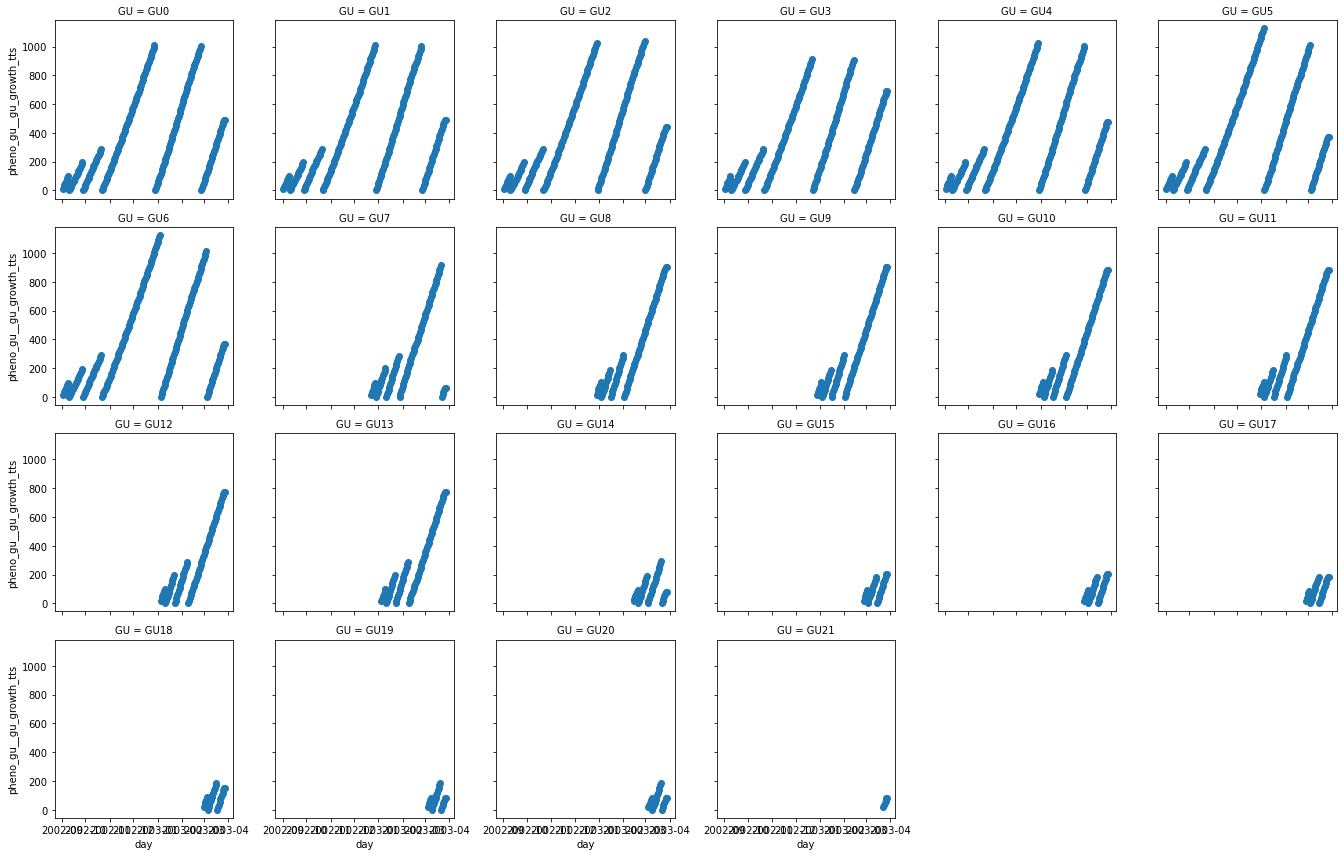

In [9]:
ds_out.plot.scatter(x='day', y='pheno_gu__gu_growth_tts', col='GU', col_wrap=6)

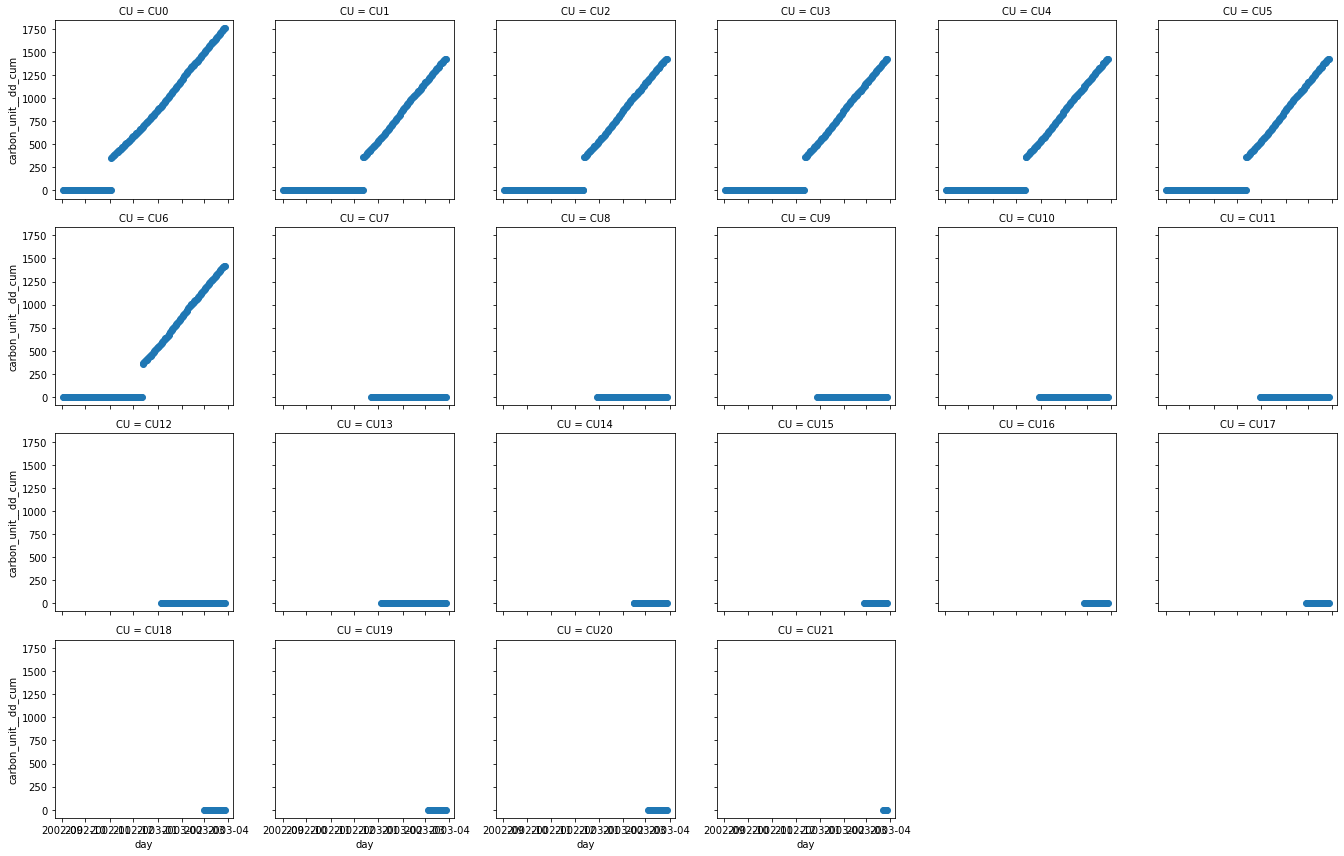

In [10]:
ds_out.plot.scatter(x='day', y='carbon_unit__dd_cum', col='CU', col_wrap=6)

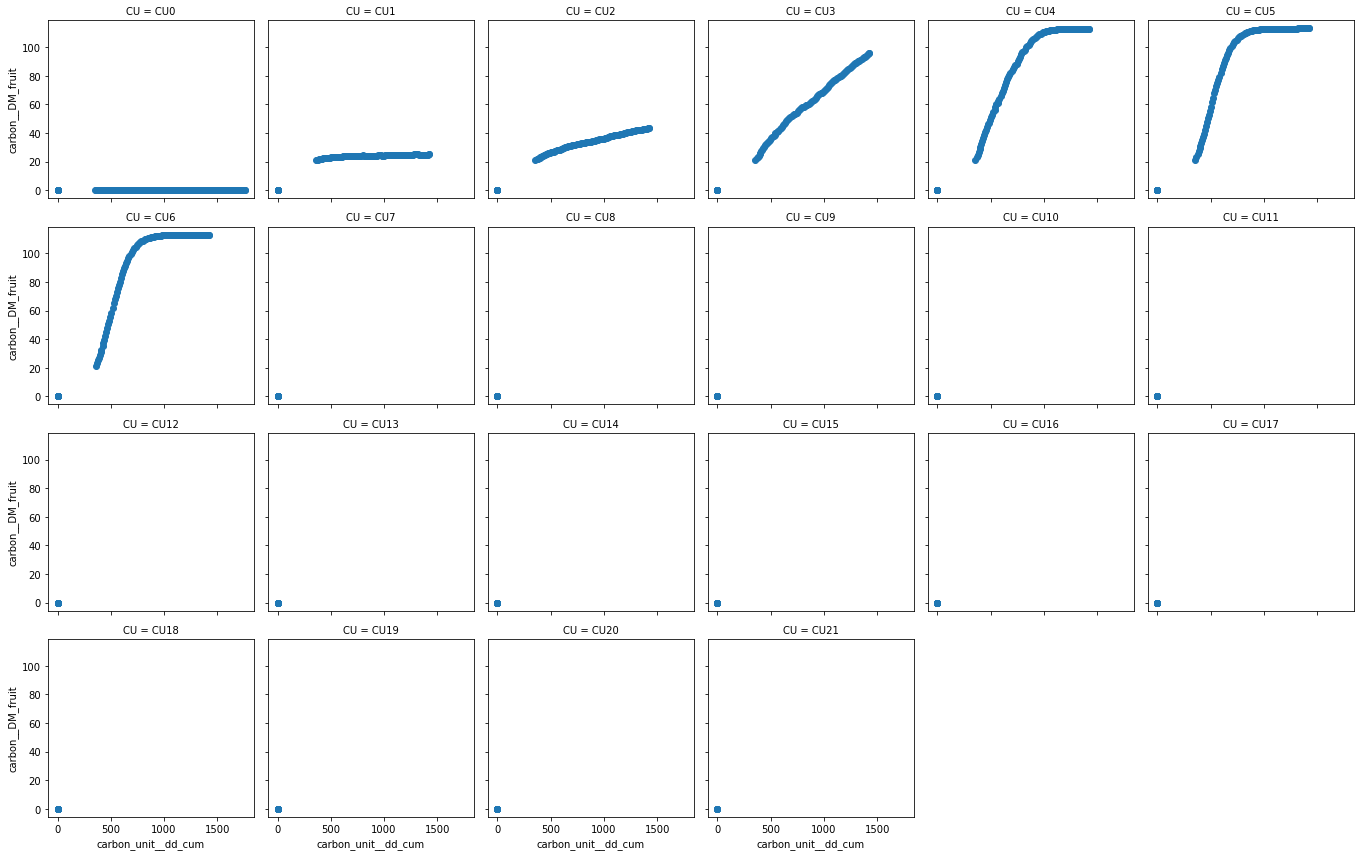

In [11]:
ds_out.plot.scatter(x='carbon_unit__dd_cum', y='carbon__DM_fruit', col='CU', col_wrap=6)

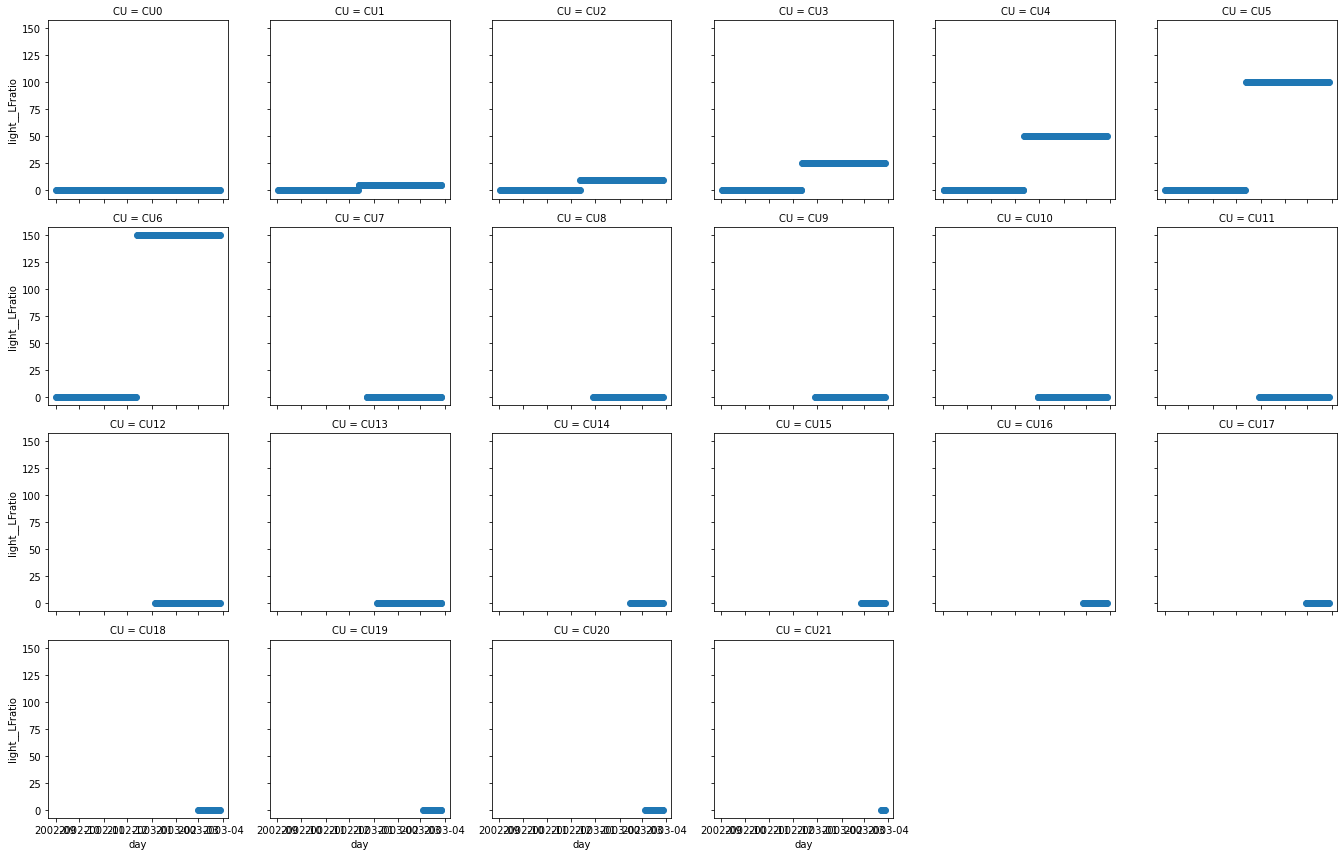

In [12]:
ds_out.plot.scatter(x='day', y='light__LFratio', col='CU', col_wrap=6)